# ENHANCED PLANT DISEASE DETECTOR
#### Group: 12
#### Dataset: PlantVillage (https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)
#### Runtime: 108 minutes

#### Libraries used: Numpy, OS, OpenCV, Matplotlib, Tensorflow, Lime

### 1. Importing all the necessary libraries.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

### 2. Loading the images, rescaling and performing validation split.

In [3]:
train_dir = r"C:\Users\91909\Desktop\ML\DATA\Plant_Disease_New\color"

In [4]:
IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 64

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             validation_split=0.2,) # No data augmentation needed as dataset is already well augmented

data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

images, labels = next(data_generator)

Found 54305 images belonging to 38 classes.


### 3. Preview of the dataset.

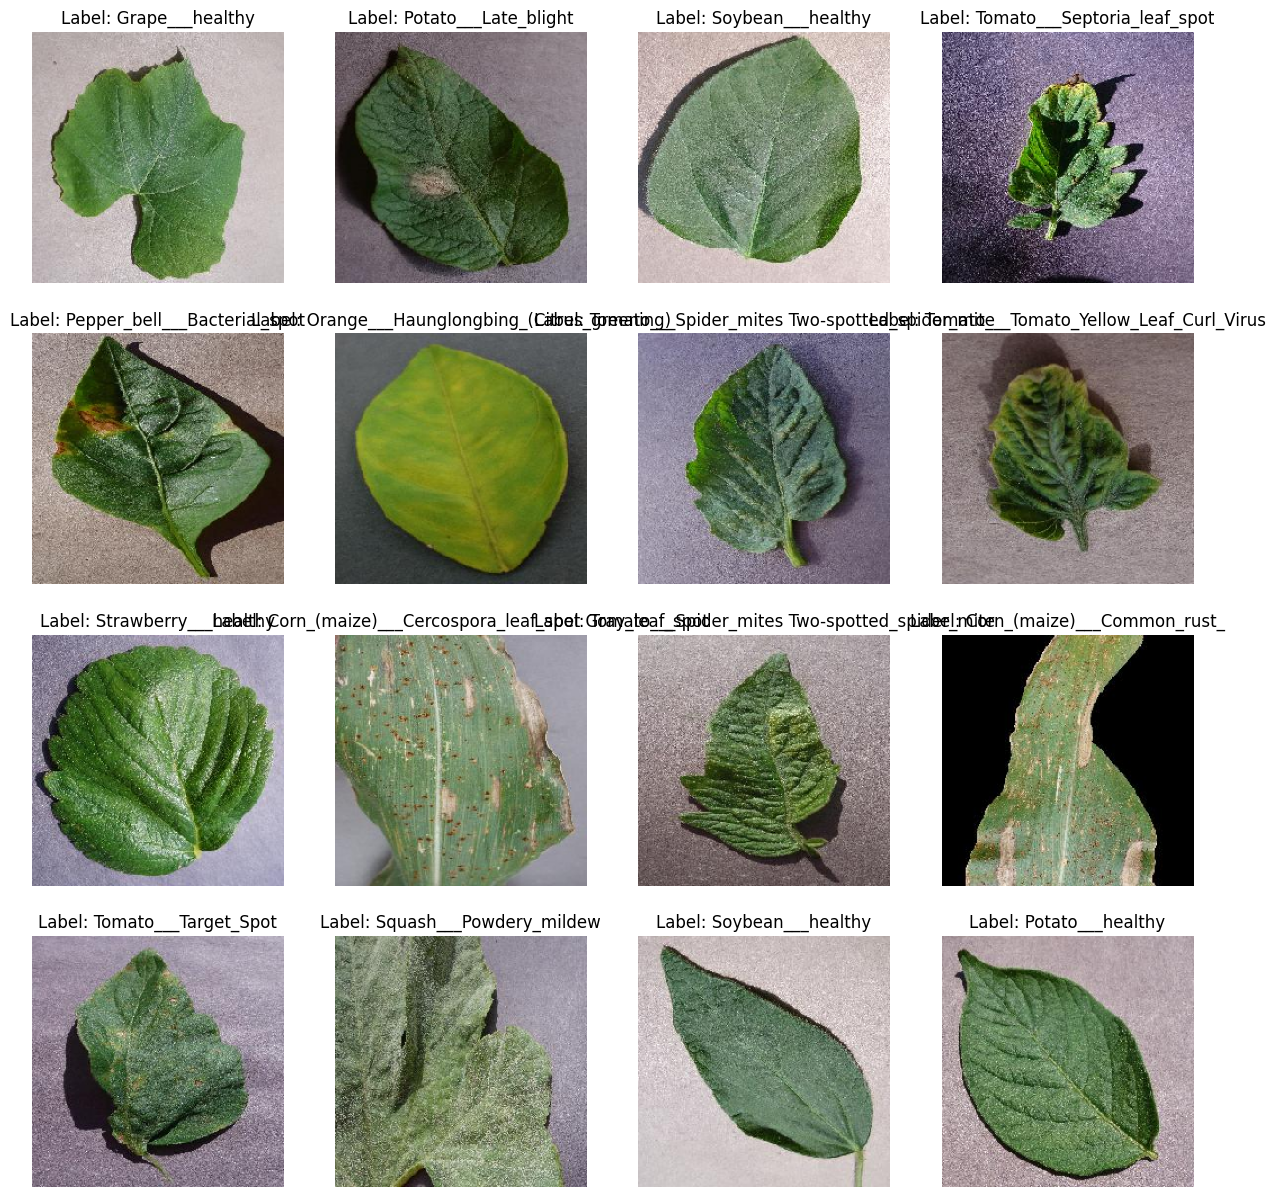

In [6]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {list(data_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis('off')
plt.show()

### 4. Displaying the distribution of the data.

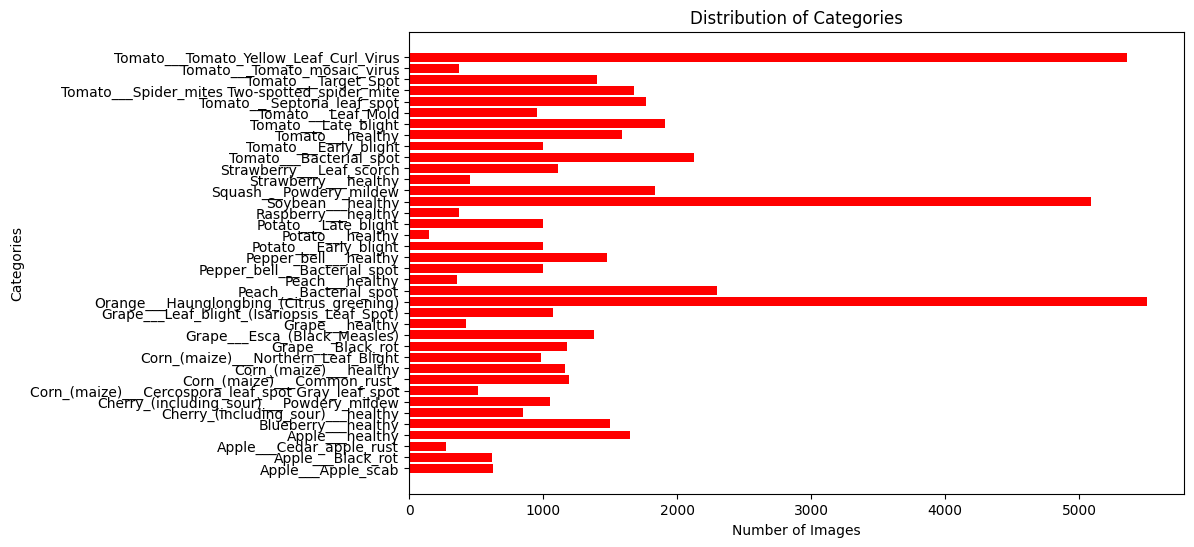

In [9]:
cat_counts = {category: len(os.listdir(os.path.join(train_dir, category)))
                   for category in os.listdir(train_dir)
                   if os.path.isdir(os.path.join(train_dir, category))}

categories = list(cat_counts.keys())
counts = list(cat_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(categories, counts, color='red')
plt.xlabel('Number of Images')
plt.ylabel('Categories')
plt.title('Distribution of Categories')
plt.show()

### 5. Loading data for training and validation.

In [7]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


### 6. Importing Xception model.

In [11]:
from tensorflow.keras.applications.xception import Xception

### 7. Building new Dense layers atop the base model.

In [12]:
base_model = Xception(weights='imagenet' ,include_top=False , input_shape=(224,224,3), pooling='max' )

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(38, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

### 8. Using Adamax optimizer with custom learning rate.

In [ ]:
model.compile(tf.keras.optimizers.Adamax(learning_rate = 0.005), # Learning rate of 0.005 was set after test training multiple times with different values
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.build(input_shape=(None, 224, 224, 3))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

### 9. Defining early stopping to stop overfitting during trining of the model.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.005,
                               patience=5,
                               restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

In [13]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
679/679 [==============================] - 534s 770ms/step - loss: 0.8807 - accuracy: 0.7473 - val_loss: 0.3636 - val_accuracy: 0.8837
Epoch 2/30
679/679 [==============================] - 366s 539ms/step - loss: 0.4712 - accuracy: 0.8493 - val_loss: 0.2869 - val_accuracy: 0.9062
Epoch 3/30
679/679 [==============================] - 367s 540ms/step - loss: 0.3645 - accuracy: 0.8831 - val_loss: 0.2697 - val_accuracy: 0.9111
Epoch 4/30
679/679 [==============================] - 367s 541ms/step - loss: 0.3155 - accuracy: 0.8978 - val_loss: 0.2325 - val_accuracy: 0.9225
Epoch 5/30
679/679 [==============================] - 371s 547ms/step - loss: 0.2752 - accuracy: 0.9086 - val_loss: 0.2195 - val_accuracy: 0.9289
Epoch 6/30
679/679 [==============================] - 368s 541ms/step - loss: 0.2532 - accuracy: 0.9149 - val_loss: 0.2206 - val_accuracy: 0.9297
Epoch 7/30
679/679 [==============================] - 367s 541ms/step - loss: 0.2314 - accuracy: 0.9237 - val_loss: 0.2041 -

### 94% accuracy achieved.
### 10. Plotting the loss and accuracy to check for overfitting.

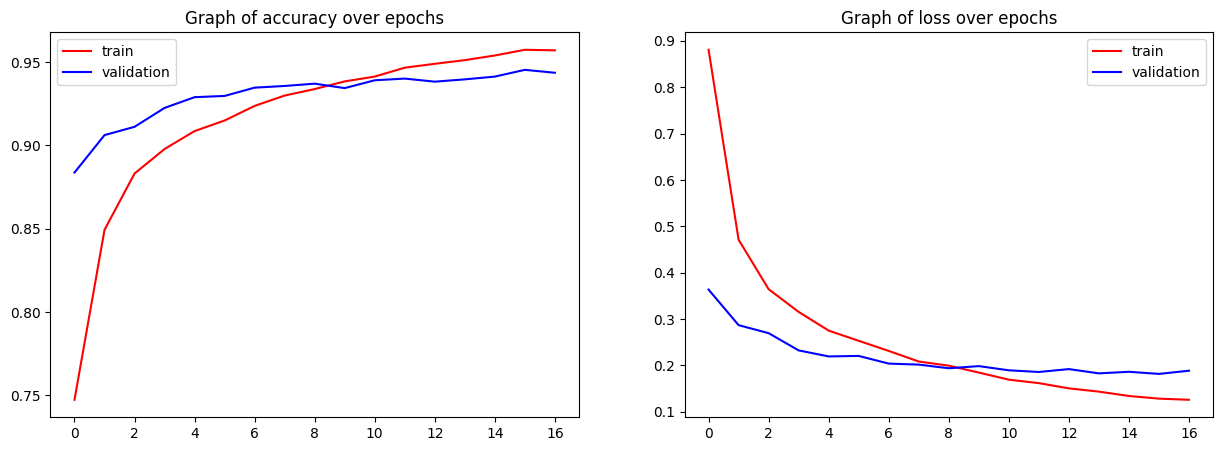

In [14]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="blue", label="validation")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="blue", label="validation")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

### 11. Minimal overfitting observed as the both the graphs of training and validation converge together.

### 12. Saving the model for future uses.

In [18]:
model.save('finalmodel.h5')

### 13. Testing the model on a random image from the dataset.

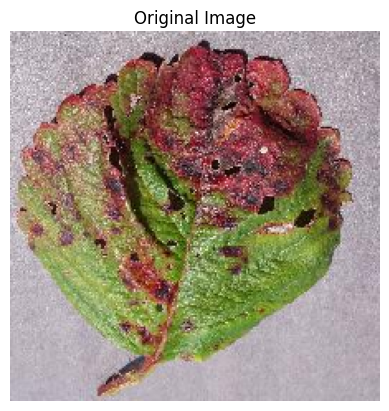

1/1 [==============================] - 0s 51ms/step
Predicted Class: Strawberry___Leaf_scorch
Actual Class: Strawberry___Leaf_scorch


In [21]:
images, labels = next(validation_generator)

selected_image = images[0]
selected_label = labels[0]

plt.imshow(selected_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

image_for_prediction = np.expand_dims(selected_image, axis=0)

predicted_probs = model.predict(image_for_prediction)
predicted_class = np.argmax(predicted_probs, axis=1)

actual_class = np.argmax(selected_label)

class_names = list(validation_generator.class_indices.keys())

predicted_class_name = class_names[predicted_class[0]]
actual_class_name = class_names[actual_class]

print(f"Predicted Class: {predicted_class_name}")
print(f"Actual Class: {actual_class_name}")

### 14. Importing lime library to explain the decision factors of the model.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 10/1000 [00:00<00:21, 46.24it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 20/1000 [00:00<00:19, 49.45it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 30/1000 [00:00<00:19, 48.53it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 40/1000 [00:00<00:20, 45.74it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 50/1000 [00:01<00:19, 48.22it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 60/1000 [00:01<00:19, 49.04it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 70/1000 [00:01<00:18, 50.61it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 80/1000 [00:01<00:18, 50.85it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 90/1000 [00:01<00:17, 51.54it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 100/1000 [00:01<00:17, 51.90it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 110/1000 [00:02<00:17, 51.75it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 120/1000 [00:02<00:16, 52.79it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 130/1000 [00:02<00:16, 52.63it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 140/1000 [00:02<00:16, 53.44it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 150/1000 [00:02<00:16, 50.35it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 160/1000 [00:03<00:16, 51.46it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 170/1000 [00:03<00:16, 50.90it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 180/1000 [00:03<00:15, 51.67it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 190/1000 [00:03<00:15, 52.29it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 200/1000 [00:03<00:15, 52.98it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 210/1000 [00:04<00:14, 52.83it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 220/1000 [00:04<00:14, 52.98it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 230/1000 [00:04<00:14, 53.35it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 240/1000 [00:04<00:14, 53.08it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 250/1000 [00:04<00:14, 52.58it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 260/1000 [00:05<00:14, 51.36it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 270/1000 [00:05<00:14, 51.14it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 280/1000 [00:05<00:14, 51.27it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 290/1000 [00:05<00:13, 52.07it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 300/1000 [00:05<00:13, 52.11it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 310/1000 [00:06<00:13, 51.98it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 320/1000 [00:06<00:12, 52.64it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 330/1000 [00:06<00:12, 52.22it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 340/1000 [00:06<00:13, 49.46it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 350/1000 [00:06<00:13, 49.01it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 360/1000 [00:07<00:13, 48.76it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 370/1000 [00:07<00:13, 46.63it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 380/1000 [00:07<00:14, 42.82it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 390/1000 [00:07<00:14, 43.09it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 400/1000 [00:08<00:13, 43.10it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 410/1000 [00:08<00:12, 45.49it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 420/1000 [00:08<00:12, 46.85it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 430/1000 [00:08<00:12, 47.29it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 440/1000 [00:08<00:11, 48.25it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 450/1000 [00:09<00:11, 48.72it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 460/1000 [00:09<00:10, 49.44it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 470/1000 [00:09<00:10, 50.02it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 480/1000 [00:09<00:10, 51.22it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 490/1000 [00:09<00:10, 49.69it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 500/1000 [00:09<00:09, 50.73it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 510/1000 [00:10<00:09, 50.93it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 520/1000 [00:10<00:09, 51.63it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 530/1000 [00:10<00:09, 52.13it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 540/1000 [00:10<00:08, 51.13it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 550/1000 [00:10<00:08, 52.04it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 560/1000 [00:11<00:08, 52.39it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 570/1000 [00:11<00:08, 51.77it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 580/1000 [00:11<00:08, 52.00it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 590/1000 [00:11<00:08, 51.03it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 600/1000 [00:11<00:07, 52.52it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 610/1000 [00:12<00:07, 51.94it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 620/1000 [00:12<00:07, 52.60it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 630/1000 [00:12<00:07, 52.25it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 640/1000 [00:12<00:06, 52.31it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 650/1000 [00:12<00:06, 52.05it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [00:13<00:06, 51.89it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 670/1000 [00:13<00:06, 49.82it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 680/1000 [00:13<00:06, 50.29it/s]

1/1 [==============================] - 0s 116ms/step


 69%|██████▉   | 690/1000 [00:13<00:07, 42.51it/s]

1/1 [==============================] - 0s 66ms/step


 70%|███████   | 700/1000 [00:14<00:07, 40.28it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 710/1000 [00:14<00:07, 41.03it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 720/1000 [00:14<00:06, 40.67it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 730/1000 [00:14<00:07, 38.12it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 740/1000 [00:15<00:06, 39.66it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 750/1000 [00:15<00:06, 40.72it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 760/1000 [00:15<00:05, 41.99it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 770/1000 [00:15<00:05, 40.76it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 780/1000 [00:16<00:05, 39.79it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 790/1000 [00:16<00:05, 40.71it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 800/1000 [00:16<00:04, 42.24it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 810/1000 [00:16<00:04, 43.31it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 820/1000 [00:16<00:03, 45.18it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 830/1000 [00:17<00:03, 45.47it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 840/1000 [00:17<00:03, 46.29it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 850/1000 [00:17<00:03, 45.53it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 860/1000 [00:17<00:03, 43.92it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 870/1000 [00:18<00:03, 41.52it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 880/1000 [00:18<00:02, 40.81it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 890/1000 [00:18<00:02, 42.14it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 900/1000 [00:18<00:02, 44.74it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 910/1000 [00:18<00:01, 46.78it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 920/1000 [00:19<00:01, 46.51it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 930/1000 [00:19<00:01, 48.56it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 940/1000 [00:19<00:01, 50.72it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 950/1000 [00:19<00:00, 52.14it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 960/1000 [00:19<00:00, 53.23it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 970/1000 [00:20<00:00, 52.29it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 980/1000 [00:20<00:00, 52.65it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 990/1000 [00:20<00:00, 53.42it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 1000/1000 [00:20<00:00, 48.43it/s]


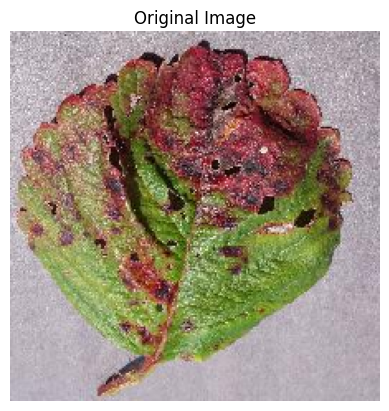

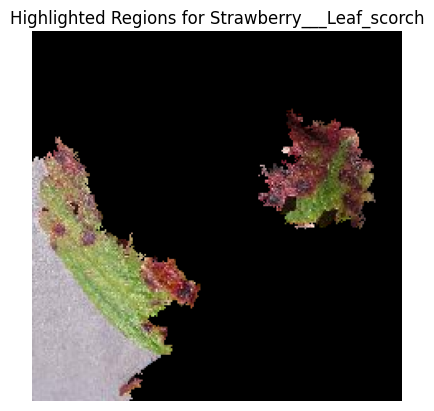

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(selected_image, model.predict, top_labels=1, hide_color=0, num_samples=1000) # 1000 iterations give satisfactory results

predicted_class_int = predicted_class[0]

temp, mask = explanation.get_image_and_mask(predicted_class_int, positive_only=True, num_features=5, hide_rest=True) # Setting num_features=5 because any numberr higher than that makes it hard to catch features

plt.imshow(selected_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.imshow(temp)
plt.title(f"Highlighted Regions for {predicted_class_name}")
plt.axis('off')
plt.show()

### 15. The model successfully predicts the disease in the plant accurately. With lime we explain the decision process with the help of highlighted features on the leaf.